In [1]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import  confusion_matrix, f1_score, precision_score, recall_score, classification_report
from tqdm.notebook import tqdm

import tensorflow as tf

print("Python used = ", sys.version)
print("Tensorflow used = ", tf.__version__)

Python used =  3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Tensorflow used =  2.3.1


In [3]:
val = pd.DataFrame(pd.read_csv("/media/HHD_2TB/baurai/chexnet/dataset/val.csv"))
print(val.shape)

(34115, 5)


In [4]:
val.head()

,image_name,image_path,label,label_name,contributed_via
0,00022520_002.png,/media/HHD2/NIH/tflow_obj_detection/images/000...,0,others,NIH
1,00022520_003.png,/media/HHD2/NIH/tflow_obj_detection/images/000...,1,nodule_mass,NIH
2,00022520_000.png,/media/HHD2/NIH/tflow_obj_detection/images/000...,1,nodule_mass,NIH
3,00022520_001.png,/media/HHD2/NIH/tflow_obj_detection/images/000...,1,nodule_mass,NIH
4,00004801_000.png,/media/HHD2/NIH/tflow_obj_detection/images/000...,0,others,NIH


In [5]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34115 entries, 0 to 34114
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_name       34115 non-null  object
 1   image_path       34115 non-null  object
 2   label            34115 non-null  int64 
 3   label_name       34115 non-null  object
 4   contributed_via  34115 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


In [6]:
val['label'] = val['label'].astype('str')

In [8]:
val.info(), val.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34115 entries, 0 to 34114
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_name       34115 non-null  object
 1   image_path       34115 non-null  object
 2   label            34115 non-null  object
 3   label_name       34115 non-null  object
 4   contributed_via  34115 non-null  object
dtypes: object(5)
memory usage: 1.3+ MB


(None, (34115, 5))

In [10]:
config = {
    "BATCH_SIZE" : 32,
    "IMAGE_SIZE" : [224, 224]
}

In [11]:
STEPS_VAL = int(np.ceil(val.shape[0] /config["BATCH_SIZE"]))
print("Steps VAL = ", STEPS_VAL)

Steps VAL =  1067


In [12]:
config["STEPS_VAL"] = STEPS_VAL
config

{'BATCH_SIZE': 32, 'IMAGE_SIZE': [224, 224], 'STEPS_VAL': 1067}

Model is saved at : /media/HHD_2TB/baurai/chexnet/saved_models/my_chexnet_model

In [13]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, preprocessing_function = None)
val = datagen.flow_from_dataframe(dataframe = val, x_col = "image_path", y_col = "label",
                                  batch_size = config["BATCH_SIZE"], class_mode = "binary",
                                  target_size = config["IMAGE_SIZE"], shuffle = False)

Found 34115 validated image filenames belonging to 2 classes.


In [14]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision available


In [15]:
# load model
with tf.device("/device:GPU:0") : 
    chexnet = tf.keras.models.load_model("/media/HHD_2TB/baurai/chexnet/saved_models/my_chexnet_model")
    print(chexnet.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
None


In [16]:
with tf.device("/device:GPU:0") :
    y_pred = chexnet.predict(val, config["STEPS_VAL"], verbose = True)

1067/1067 [==============================] - 1992s 2s/step


In [19]:
y_true = val.classes
type(y_true)

list

In [20]:
predicted_labels = []
for prob in y_pred : 
    if prob >= 0.5 : 
        predicted_labels.append(1)
    else:
        predicted_labels.append(0)

[[30149   576]
 [ 2783   607]]


[Text(0, 0.5, 'Others'), Text(0, 1.5, 'Nodular')]

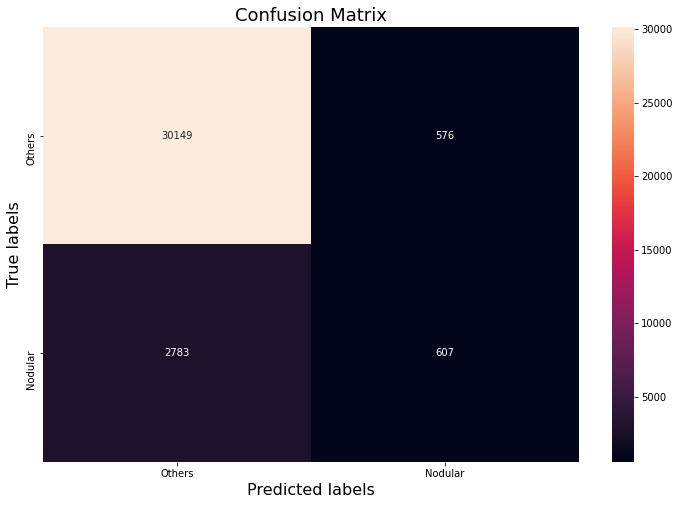

In [21]:
cm = confusion_matrix(y_true, predicted_labels)
print(cm)

plt.figure(figsize = (12, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = "d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize = 16)
ax.set_ylabel('True labels', fontsize = 16) 
ax.set_title('Confusion Matrix', fontsize = 18) 
ax.xaxis.set_ticklabels(['Others', 'Nodular'])
ax.yaxis.set_ticklabels(['Others', 'Nodular'])

In [22]:
f1 = f1_score(y_true, predicted_labels, average = "binary")
precision = precision_score(y_true, predicted_labels, average = "binary")
recall = recall_score(y_true, predicted_labels, average = "binary")
print("f1 score = ", f1)
print("precision = ", precision)
print("Recall = ", recall)

f1 score =  0.2654712442597857
precision =  0.5131022823330516
Recall =  0.17905604719764012
